In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import joblib

# Configuration
IMAGE_DIR = '/kaggle/input/new-dataset/images'
TRAIN_PATH = '/kaggle/input/new-dataset/train.csv'
TEST_PATH = '/kaggle/input/new-dataset/test.csv'

def preprocess_data():
    print("Loading data...")
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    
    # 1. Handle Date
    train_df['date'] = pd.to_datetime(train_df['date'])
    test_df['date'] = pd.to_datetime(test_df['date'])
    
    train_df['date_int'] = train_df['date'].astype(np.int64) // 10**9
    test_df['date_int'] = test_df['date'].astype(np.int64) // 10**9
    
    # 2. Log Transform Target (Price)
    train_df['log_price'] = np.log1p(train_df['price'])
    
    # 3. Log Transform Skewed Input Features (Crucial for NN performance)
    skewed_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
                   'sqft_living15', 'sqft_lot15']
    
    for col in skewed_cols:
        # Fill NA with 0 just in case, though dataset is clean
        train_df[col] = np.log1p(train_df[col].fillna(0))
        test_df[col] = np.log1p(test_df[col].fillna(0))
        print(f"Log-transformed {col}")

    # 4. Feature Selection
    drop_cols = ['id', 'date', 'price', 'log_price']
    feature_cols = [c for c in train_df.columns if c not in drop_cols]
    
    print(f"Selected {len(feature_cols)} tabular features.")
    
    # 5. Scaling
    scaler = StandardScaler()
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df[feature_cols] = scaler.transform(test_df[feature_cols])
    
    joblib.dump(scaler, 'tabular_scaler.pkl')
    
    # 6. Image Path Mapping
    def get_image_path(house_id):
        path_jpg = os.path.join(IMAGE_DIR, f"{house_id}.jpg")
        if os.path.exists(path_jpg): return path_jpg
        path_png = os.path.join(IMAGE_DIR, f"{house_id}.png")
        if os.path.exists(path_png): return path_png
        return None 

    train_df['image_path'] = train_df['id'].apply(get_image_path)
    test_df['image_path'] = test_df['id'].apply(get_image_path)
    
    print("Saving processed data...")
    train_df.to_csv('processed_train_new.csv', index=False)
    test_df.to_csv('processed_test_new.csv', index=False)
    print("Done. Files saved.")

if __name__ == "__main__":
    preprocess_data()

Loading data...
Log-transformed sqft_living
Log-transformed sqft_lot
Log-transformed sqft_above
Log-transformed sqft_basement
Log-transformed sqft_living15
Log-transformed sqft_lot15
Selected 19 tabular features.
Saving processed data...
Done. Files saved.


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_final_performance(model, val_loader, device):
    """
    Loads the best model state and evaluates on the validation set.
    """
    print("Loading best model weights for evaluation...")
    model.load_state_dict(torch.load('new_model.pth'))
    model.eval()
    
    actuals = []
    predictions = []

    with torch.no_grad():
        for images, tabular, targets in val_loader:
            images = images.to(device)
            tabular = tabular.to(device)
            
            # Predict
            outputs = model(images, tabular)
            
            # Inverse Log Transform (getting back to real prices)
            # exp(pred) - 1
            preds_exp = np.expm1(outputs.cpu().numpy().flatten())
            targets_exp = np.expm1(targets.cpu().numpy().flatten())
            
            predictions.extend(preds_exp)
            actuals.extend(targets_exp)
            
    # Calculate Metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    
    print("\n" + "="*40)
    print(" FINAL BEST MODEL RESULTS (Validation Set)")
    print("="*40)
    print(f" RMSE     : ${rmse:,.2f}")
    print(f" R² Score : {r2:.4f}")
    print("="*40 + "\n")
    
    return rmse, r2

# --- Configuration ---
BATCH_SIZE = 64
LEARNING_RATE = 1e-3 
EPOCHS = 30 # Increased epochs for better convergence
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Dataset Class ---
class RealEstateDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test
        
        # Exclude non-feature columns
        exclude = ['id', 'date', 'price', 'log_price', 'image_path', 'date_int']
        self.feature_cols = [c for c in self.data.columns if c not in exclude]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Load Image
        img_path = str(row['image_path'])
        # Handle missing/nan paths
        if img_path != 'nan' and img_path != 'None' and os.path.exists(img_path):
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        else:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
            
        if self.transform:
            image = self.transform(image)
            
        # Load Tabular
        tabular = torch.tensor(row[self.feature_cols].values.astype(np.float32))
        
        if self.is_test:
            return image, tabular, row['id']
        else:
            target = torch.tensor(row['log_price'], dtype=torch.float32)
            return image, tabular, target

# --- 2. Improved Model Architecture ---
class MultimodalNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalNet, self).__init__()
        
        # --- Image Branch ---
        # Try loading weights, fallback to pretrained=True
        try:
            from torchvision.models import ResNet18_Weights
            self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        except:
            self.cnn = models.resnet18(pretrained=True)
            
        # FREEZE CNN Backbone
        # This is crucial so the CNN doesn't destabilize the tabular learning initially
        for param in self.cnn.parameters():
            param.requires_grad = False
            
        # Replace last fc layer to project to small dim
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(num_ftrs, 64) # Project 512 -> 64
        
        # --- Tabular Branch (Robust MLP) ---
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # --- Fusion ---
        # 64 (Image) + 64 (Tabular) = 128
        self.fusion = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1) 
        )
        
    def forward(self, image, tabular):
        x_img = self.cnn(image)
        x_tab = self.tabular_branch(tabular)
        
        # Combine
        x_combined = torch.cat((x_img, x_tab), dim=1)
        output = self.fusion(x_combined)
        return output

# --- 3. Training Loop ---
def train_pipeline():
    # Transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(), # Data Augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load Data
    train_dataset = RealEstateDataset('/kaggle/working/processed_train_new.csv', transform=transform)
    
    # Split Train/Val (80/20)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize Model
    num_tab_features = len(train_dataset.feature_cols)
    model = MultimodalNet(num_tab_features).to(DEVICE)
    
    # Optimizer & Scheduler
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
    
    # Fixed Scheduler (Removed verbose=True to fix error)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    print("Starting Improved Training...")
    best_val_loss = float('inf')
    
    for epoch in range(EPOCHS):
        # TRAIN
        model.train()
        running_loss = 0.0
        for images, tabular, targets in train_loader:
            images, tabular, targets = images.to(DEVICE), tabular.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        
        # VALIDATE
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, tabular, targets in val_loader:
                images, tabular, targets = images.to(DEVICE), tabular.to(DEVICE), targets.to(DEVICE)
                outputs = model(images, tabular)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Step Scheduler
        prev_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        curr_lr = optimizer.param_groups[0]['lr']
        
        # Custom Print
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {curr_lr:.2e}")
        
        # Save Best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'new_model.pth')
            
    print(f"Training Complete. Best Val Loss: {best_val_loss:.4f}")

    # --- NEW: CALCULATE RMSE & R2 ---
    # Load the best weights into the model structure we already have
    evaluate_final_performance(model, val_loader, DEVICE)
    
    # Inference
    model.load_state_dict(torch.load('new_model.pth'))
    model.eval()
    
    test_dataset = RealEstateDataset('/kaggle/working/processed_test_new.csv', transform=transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    ids = []
    preds = []
    
    print("Generating predictions...")
    with torch.no_grad():
        for images, tabular, id_batch in test_loader:
            images, tabular = images.to(DEVICE), tabular.to(DEVICE)
            outputs = model(images, tabular)
            # Inverse Log Transform: exp(x) - 1
            actual_preds = np.expm1(outputs.cpu().numpy().flatten())
            
            ids.extend(id_batch.numpy())
            preds.extend(actual_preds)
            
    submission = pd.DataFrame({'id': ids, 'predicted_price': preds})
    submission.to_csv('new_pred.csv', index=False)
    print("Improved Multimodal Predictions Saved to 'new_pred.csv'.")

if __name__ == "__main__":
    train_pipeline()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Starting Improved Training...
Epoch 1/30 | Train Loss: 7.0645 | Val Loss: 1.3774 | LR: 1.00e-03
Epoch 2/30 | Train Loss: 0.9965 | Val Loss: 0.8378 | LR: 1.00e-03
Epoch 3/30 | Train Loss: 0.6319 | Val Loss: 0.5361 | LR: 1.00e-03
Epoch 4/30 | Train Loss: 0.4532 | Val Loss: 0.4070 | LR: 1.00e-03
Epoch 5/30 | Train Loss: 0.3755 | Val Loss: 0.3844 | LR: 1.00e-03
Epoch 6/30 | Train Loss: 0.3056 | Val Loss: 0.2249 | LR: 1.00e-03
Epoch 7/30 | Train Loss: 0.2649 | Val Loss: 0.2325 | LR: 1.00e-03
Epoch 8/30 | Train Loss: 0.2459 | Val Loss: 0.2349 | LR: 1.00e-03
Epoch 9/30 | Train Loss: 0.2139 | Val Loss: 0.1308 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.1973 | Val Loss: 0.1478 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.1750 | Val Loss: 0.1848 | LR: 1.00e-03
Epoch 12/30 | Train Loss: 0.1647 | Val Loss: 0.1514 | LR: 1.00e-03
Epoch 13/30 | Train Loss: 0.1419 | Val Loss: 0.1330 | LR: 5.00e-04
Epoch 14/30 | Train Loss: 0.1228 | Val Loss: 0.1237 | LR: 5.00e-04
Epoch 15/30 | Train Loss: 0.1151 | Val Lo

--- Step 1: Visual Features ---
Extracting features from /kaggle/working/processed_train_new.csv...


100%|██████████| 254/254 [01:24<00:00,  3.00it/s]


Extracting features from /kaggle/working/processed_test_new.csv...


100%|██████████| 85/85 [00:29<00:00,  2.89it/s]


--- Step 2: Merging & Engineering ---
Adding Geospatial Clusters...

--- Step 3: Training Ensemble (Voting Regressor) ---

 FINAL ENSEMBLE RESULTS
 RMSE     : $119,336.61
 R² Score : 0.8865

Ensemble Predictions saved to 'enrollno_final.csv'.
Generating Feature Importance Plot...
Plot saved.


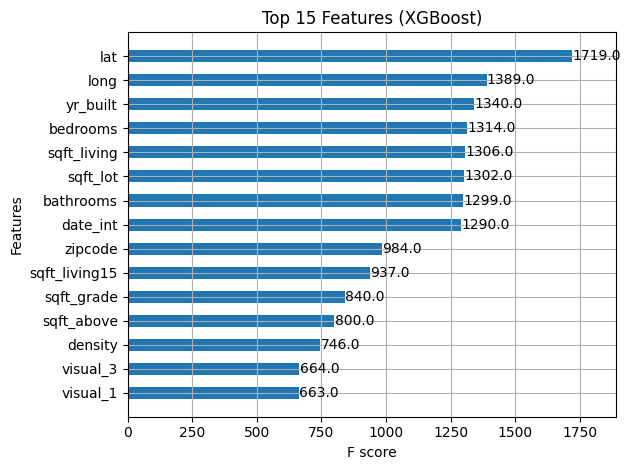

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
from tqdm import tqdm
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# --- Configuration ---
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = '/kaggle/working/new_model.pth'

# --- 1. Define Dataset & Model for Extraction (Same as before) ---
class RealEstateDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = str(row['image_path'])
        if img_path != 'nan' and img_path != 'None' and os.path.exists(img_path):
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        else:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))   
        if self.transform:
            image = self.transform(image)
        return image, row['id']

class MultimodalNet(nn.Module):
    def __init__(self):
        super(MultimodalNet, self).__init__()
        try:
            from torchvision.models import ResNet18_Weights
            self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        except:
            self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 64) 
        
    def forward(self, image):
        return self.cnn(image)

def extract_embeddings(csv_file, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dataset = RealEstateDataset(csv_file, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Extracting features from {csv_file}...")
    all_ids = []
    all_embeddings = []
    with torch.no_grad():
        for images, ids in tqdm(loader):
            images = images.to(DEVICE)
            embeddings = model(images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_ids.extend(ids.numpy())
            
    all_embeddings = np.vstack(all_embeddings)
    cols = ['id'] + [f'visual_{i}' for i in range(all_embeddings.shape[1])]
    data = np.column_stack((all_ids, all_embeddings))
    df = pd.DataFrame(data, columns=cols)
    df['id'] = df['id'].astype(int)
    return df

# --- 2. Advanced Feature Engineering ---
def add_spatial_clusters(train_df, test_df, n_clusters=20):
    print("Adding Geospatial Clusters...")
    # Combine coords to learn global clusters
    coords = pd.concat([train_df[['lat', 'long']], test_df[['lat', 'long']]])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(coords)
    
    train_df['cluster'] = kmeans.predict(train_df[['lat', 'long']])
    test_df['cluster'] = kmeans.predict(test_df[['lat', 'long']])
    
    # One-hot encode the clusters? 
    # Tree models handle integers fine, but let's leave as int for now.
    return train_df, test_df

def add_interactions(df):
    # Interaction: Big House * High Grade = Exponential Value
    df['sqft_grade'] = df['sqft_living'] * df['grade']
    # Interaction: Living Area / Lot Area = Density
    df['density'] = df['sqft_living'] / (df['sqft_lot'] + 1)
    return df

# --- 3. Main Execution Flow ---
def run_hybrid_pipeline():
    # A. Feature Extraction
    print("--- Step 1: Visual Features ---")
    model = MultimodalNet().to(DEVICE)
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    cnn_state_dict = {k.replace('cnn.', ''): v for k, v in state_dict.items() if 'cnn.' in k}
    model.cnn.load_state_dict(cnn_state_dict)
    model.eval()
    
    train_visual = extract_embeddings('/kaggle/working/processed_train_new.csv', model).drop_duplicates(subset=['id'])
    test_visual = extract_embeddings('/kaggle/working/processed_test_new.csv', model).drop_duplicates(subset=['id'])

    # B. Merge
    print("--- Step 2: Merging & Engineering ---")
    train_df = pd.read_csv('/kaggle/input/new-dataset/train.csv')
    test_df = pd.read_csv('/kaggle/input/new-dataset/test.csv')
    
    # Add Geospatial Clusters (NEW)
    train_df, test_df = add_spatial_clusters(train_df, test_df)
    
    train_full = pd.merge(train_df, train_visual, on='id', how='left')
    test_full = pd.merge(test_df, test_visual, on='id', how='left')

    # C. Preprocess
    def preprocess(df):
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df['date_int'] = df['date'].astype(np.int64) // 10**9
        
        # Add Interaction Features (NEW)
        df = add_interactions(df)
        
        drop_cols = ['id', 'date', 'price']
        cols = [c for c in df.columns if c not in drop_cols]
        df[cols] = df[cols].fillna(0)
        return df[cols]

    X = preprocess(train_full)
    y = np.log1p(train_full['price'])
    X_test = preprocess(test_full)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # D. Ensemble Training (NEW)
    print("\n--- Step 3: Training Ensemble (Voting Regressor) ---")
    
    # Model 1: HistGradientBoosting (Fast & Accurate)
    hgb = HistGradientBoostingRegressor(learning_rate=0.05, max_iter=1000, random_state=42)
    
    # Model 2: XGBoost (The King of Tabular)
    xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
    
    # Model 3: Random Forest (Robustness)
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
    
    # Voting Regressor (Averages the predictions)
    # We give slightly more weight to Gradient Boosting methods
    ensemble = VotingRegressor(
        estimators=[('hgb', hgb), ('xgb', xgb_model), ('rf', rf)],
        weights=[2, 2, 1] 
    )
    
    ensemble.fit(X_train, y_train)
    
    # Evaluate
    val_preds = np.expm1(ensemble.predict(X_val))
    y_val_actual = np.expm1(y_val)
    
    rmse = np.sqrt(mean_squared_error(y_val_actual, val_preds))
    r2 = r2_score(y_val_actual, val_preds)
    
    print("\n" + "="*40)
    print(" FINAL ENSEMBLE RESULTS")
    print("="*40)
    print(f" RMSE     : ${rmse:,.2f}")
    print(f" R² Score : {r2:.4f}")
    print("="*40 + "\n")
    
    # E. Save Submission
    test_preds = np.expm1(ensemble.predict(X_test))
    
    submission = pd.DataFrame({
        'id': test_df['id'],
        'predicted_price': test_preds
    })
    submission.to_csv('enrollno_final_updated.csv', index=False)
    print("Ensemble Predictions saved to 'enrollno_final.csv'.")
    
    # F. Feature Importance (Using XGBoost for visualization)
    print("Generating Feature Importance Plot...")
    xgb_model.fit(X_train, y_train) # Fit single model to get importance
    xgb.plot_importance(xgb_model, max_num_features=15, height=0.5)
    plt.title('Top 15 Features (XGBoost)')
    plt.tight_layout()
    plt.savefig('hybrid_feature_importance_new.png')
    print("Plot saved.")

if __name__ == "__main__":
    run_hybrid_pipeline()

Initializing Grad-CAM Visualization...
Generating explanations for 10 samples...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be r

Done. Visualization saved to 'explainability_report.png'.


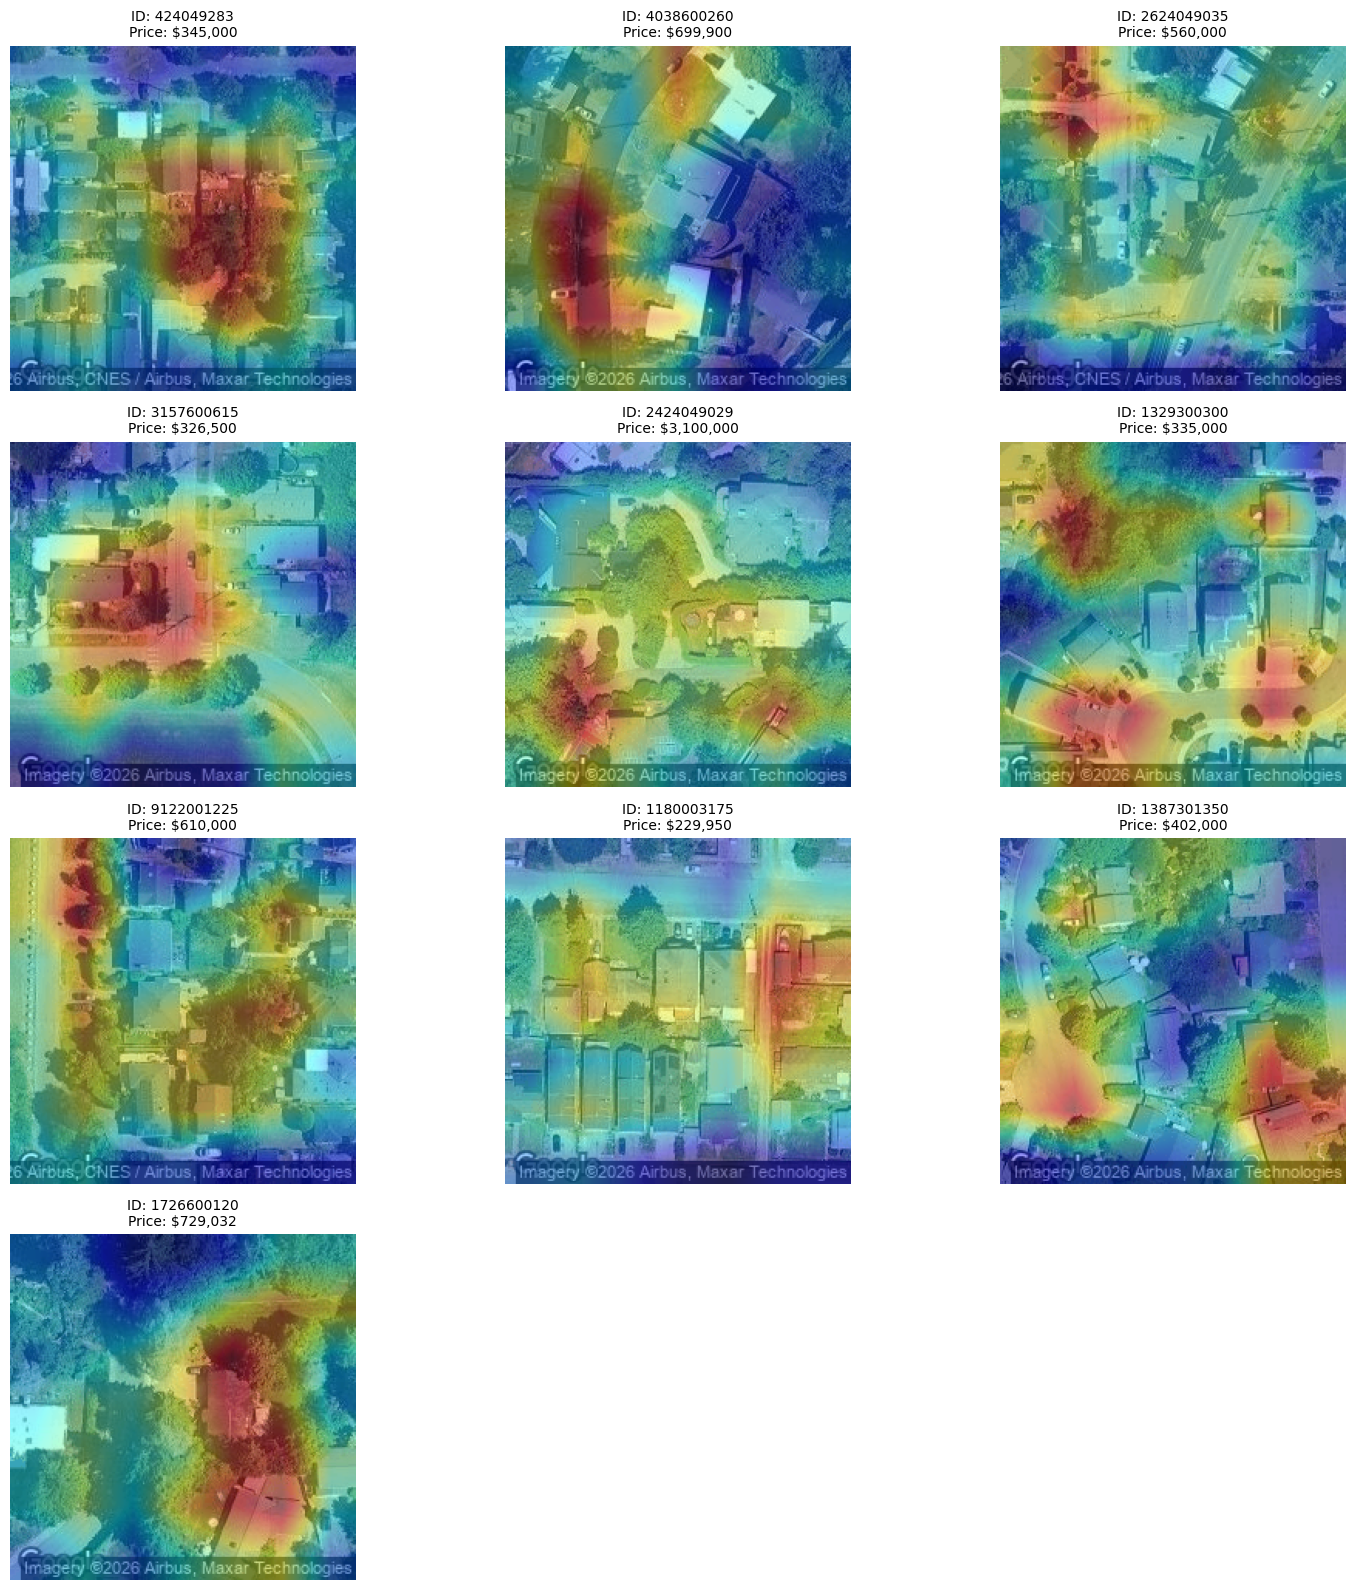

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = '/kaggle/working/new_model.pth' # The CNN trained in Step 2
CSV_PATH = '/kaggle/working/processed_train_new.csv' # We visualize Train data to compare with known prices
NUM_SAMPLES = 10 # Number of images to generate

# --- 1. Re-define Model Architecture (Must Match Training) ---
class MultimodalNet(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalNet, self).__init__()
        
        # Image Branch
        try:
            from torchvision.models import ResNet18_Weights
            self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        except:
            self.cnn = models.resnet18(pretrained=True)
            
        # Match the projection layer from training
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 64)
        
        # Tabular Branch (Structure must match for loading weights, even if unused for CAM)
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1) 
        )
        
    def forward(self, image, tabular):
        x_img = self.cnn(image)
        x_tab = self.tabular_branch(tabular)
        x_combined = torch.cat((x_img, x_tab), dim=1)
        output = self.fusion(x_combined)
        return output

# --- 2. Dataset Loader ---
class InferenceDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
        # Exclude non-feature columns
        exclude = ['id', 'date', 'price', 'log_price', 'image_path', 'date_int']
        # Identify interaction features if they exist, otherwise stick to basics
        # We reload the original processed columns
        self.feature_cols = [c for c in self.data.columns if c not in exclude]
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = str(row['image_path'])
        
        if img_path != 'nan' and img_path != 'None' and os.path.exists(img_path):
            original_img = Image.open(img_path).convert('RGB')
            original_img = original_img.resize((224, 224))
        else:
            original_img = Image.new('RGB', (224, 224), color=(0,0,0))
            
        image_tensor = self.transform(original_img)
        tabular = torch.tensor(row[self.feature_cols].values.astype(np.float32))
        
        return image_tensor, tabular, np.array(original_img), row['id'], row.get('price', 0)

# --- 3. Grad-CAM Implementation ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activations = output
        
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def __call__(self, image_tensor, tabular_tensor):
        self.model.eval()
        
        # Forward pass
        output = self.model(image_tensor.unsqueeze(0), tabular_tensor.unsqueeze(0))
        
        # Backward pass
        self.model.zero_grad()
        output.backward()
        
        # Generate Heatmap
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)
        
        return cam, output.item()

# --- 4. Main Execution ---
def run_explainability():
    print("Initializing Grad-CAM Visualization...")
    
    dataset = InferenceDataset(CSV_PATH)
    # Pick random indices
    indices = np.random.choice(len(dataset), NUM_SAMPLES, replace=False)
    
    # Initialize Model
    num_features = len(dataset.feature_cols)
    model = MultimodalNet(num_features).to(DEVICE)
    
    # Load weights loosely (allowing for some missing keys if strict match fails)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    except RuntimeError:
        print("Warning: Strict loading failed, trying non-strict...")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE), strict=False)
    
    # Target Layer: Last Convolutional Block of ResNet18
    target_layer = model.cnn.layer4[-1]
    grad_cam = GradCAM(model, target_layer)
    
    print(f"Generating explanations for {NUM_SAMPLES} samples...")
    
    plt.figure(figsize=(15, 4 * ((NUM_SAMPLES + 2) // 3))) # Dynamic height
    
    for i, idx in enumerate(indices):
        img_tensor, tab_tensor, original_img_np, house_id, true_price = dataset[idx]
        img_tensor = img_tensor.to(DEVICE)
        tab_tensor = tab_tensor.to(DEVICE)
        
        # Generate Heatmap
        heatmap, pred_log_price = grad_cam(img_tensor, tab_tensor)
        
        # Overlay
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        superimposed = np.uint8(0.6 * original_img_np + 0.4 * heatmap_colored)
        
        # Plotting
        ax = plt.subplot(NUM_SAMPLES // 3 + 1, 3, i + 1)
        plt.imshow(superimposed)
        plt.title(f"ID: {house_id}\nPrice: ${true_price:,.0f}", fontsize=10)
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('explainability_report_new.png')
    print("Done. Visualization saved to 'explainability_report.png'.")

if __name__ == "__main__":
    run_explainability()